In [ ]:
# Ridge Regression - on Design Matrix

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd  
from sklearn.datasets import load_boston

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)



In [2]:
# Rescale/Normalize and Standardize the data sets
#----------------------------------------------
def normalizeX (x):
    #  Rescale the input - X
    nx = MinMaxScaler().fit_transform(x)
    
    return nx

def standardizeXy (x):
    # Standardize both input-X and target-y
    scaler = StandardScaler()
    sx = scaler.fit_transform(x)
    #sy = scaler.fit_transform(y)    
    
    return sx

In [3]:
# Generate random data
n = 40     # number of points
m = 5      # degree of polynomial

# sort the random values
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)


In [4]:
# Create the Franke Function

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4
    
z = FrankeFunction(x, y)

# Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
z_1 = np.ravel(z)


In [5]:
# Create the design matrix
#X= create_X(x_1, y_1, m)

# Function for creating a design X-matrix with rows [1, x, y, x^2, xy, y^2 , etc.]
# Input is x and y mesh or raveled mesh, keyword agruments n is the degree of the polynomial you want to fit.
    
def DesignMatriX(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    
    N = len(x)
    l = int((n+1) * (n+2)/2)  # Number of elements in beta
    X = np.ones((N,l))
    
    for i in range(1, n+1):
        q = int((i) * (i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    
    return X

X = DesignMatriX(x_1, y_1, m)

In [6]:
y = z_1.reshape(-1,1)

In [7]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=1)

X.shape, y.shape

((1600, 21), (1600, 1))

In [8]:
#----------------------------------------------
#           Ridge Regression (coded)            #
#----------------------------------------------
def coded_RidgeRegression(X, y):
    
    n_alphas = 100
    alphas = np.logspace(-3, 4, n_alphas)

    coefs_list = []          # betaRidge - coefficients.
    df_list = []             # effective degrees of freedom - df(λ)
    mse = []                 # MSE
    r2 = []                  # R2 score
    
    for i in alphas : #range(0, n_alphas, 1):
        lambd_a = i
        
        # betaRidge
        coefs = np.dot(np.linalg.inv(np.dot(X.T, X) + np.identity(X.T.shape[0]) * lambd_a), np.dot(X.T, y))
        
        # The singular values are the diagonal entries of the matrix => [X=UDVT=>(U,s,VT)]
        _, s, _ = np.linalg.svd(X)
        df = np.sum(np.square(s) / (np.square(s) + lambd_a))
        
        coefs_list.append(coefs.ravel())
        df_list.append(df)
        y_tilde = X.dot(coefs).ravel()
        
        mse.append( mean_squared_error(y, y_tilde) )
        r2.append( r2_score(y,  y_tilde) )
        
    coefs_list = np.asarray(coefs_list) 
    df_list = np.asarray(df_list)
    mse = np.asarray(mse)
    r2 = np.asarray(r2)
    
    return coefs_list, df_list, mse, r2


In [9]:
#----------------------------------------------
#           Ridge Regression (Skl)            #
#----------------------------------------------
def skl_RidgeRegression (X,y) :
    n_alphas = 100
    alphas = np.logspace(-5, 4, n_alphas)

    ridge = Ridge(normalize = True)

    coefs = []
    mse  = []
    r2 = []

    for a in alphas:
        ridge.set_params(alpha = a)
        ridge.fit(X, y)

        coefs.append(ridge.coef_.ravel())       # coefficients

        ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
        y_tilde = ridge.predict(X)              # Use this model to predict the test data
        
        mse.append(mean_squared_error(y, y_tilde).ravel())   # MSE test 
        r2.append(ridge.score(X, y).ravel())                 # R2 score
        #r2x.append(r2_score(y, y_tilde).ravel())
        
    return coefs, mse, r2, alphas


In [33]:
# Ridge Regression on test data

# Call own code for Ridge Regression
#coefs, df, mse, r2 = coded_RidgeRegression (X_test, y_test)

# using codes from sklearn builtin functions
coefs, mse, r2, df = skl_RidgeRegression (X_test, y_test)

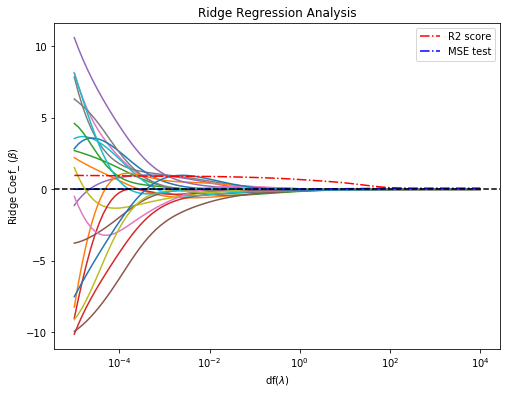

In [34]:
# df(λ) - βcoefficients

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
#plt.gca().invert_xaxis()

ax.plot(df, coefs)
ax.plot(df, r2, 'r-.', label='R2 score')
ax.plot(df, mse, 'b-.', label='MSE test')

plt.xlabel(r'df($\lambda$)')
plt.ylabel(r'Ridge Coef_ ($\beta$)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Ridge Regression Analysis')
ax.legend(loc='best')
plt.savefig('RidgeDMcod-coef_.png')
plt.show()

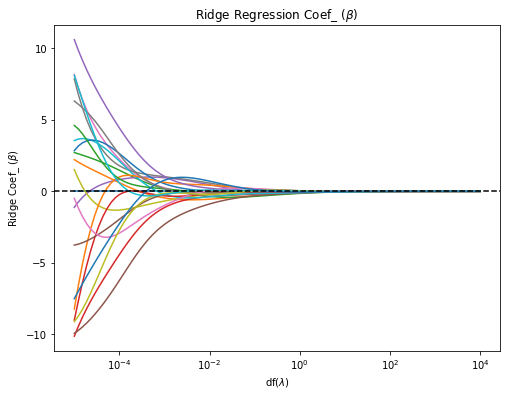

In [35]:
# df(λ) - βcoefficients

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
#plt.gca().invert_xaxis()

ax.plot(df, coefs)
#ax.plot(df, r2, 'r-.', label='R2 score')
#ax.plot(df, mse, 'b-.', label='MSE test')

plt.xlabel(r'df($\lambda$)')
plt.ylabel(r'Ridge Coef_ ($\beta$)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title(r'Ridge Regression Coef_ ($\beta$)')
#ax.legend(loc='best')
plt.savefig('RidgeDMcod-coef_.png')
plt.show()

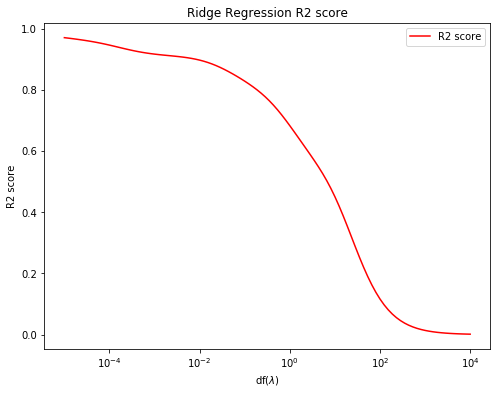

In [38]:
# df(λ) - βcoefficients

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
#plt.gca().invert_xaxis()

#ax.plot(df, coefs)
ax.plot(df, r2, 'r', label='R2 score')
#ax.plot(df, mse, 'b-.', label='MSE test')

plt.xlabel(r'df($\lambda$)')
plt.ylabel('R2 score')
plt.title('Ridge Regression R2 score')
ax.legend(loc='best')
plt.savefig('RidgeDMcod-R2.png')
plt.show()

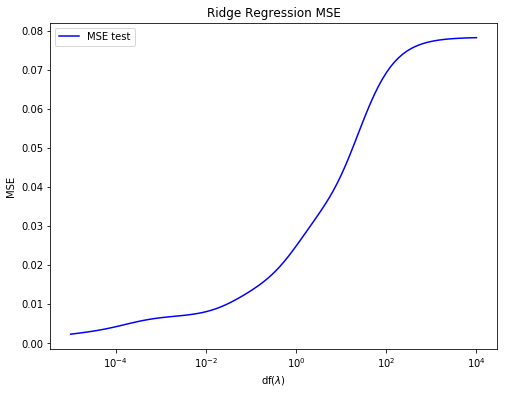

In [39]:
# df(λ) - βcoefficients

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
#plt.gca().invert_xaxis()

#ax.plot(df, coefs)
#ax.plot(df, r2, 'r-.', label='R2 score')
ax.plot(df, mse, 'b', label='MSE test')

plt.xlabel(r'df($\lambda$)')
plt.ylabel('MSE ')
plt.title('Ridge Regression MSE')
ax.legend(loc='best')
plt.savefig('RidgeDMcod-MSE.png')
plt.show()
#--------------------------------------------------------


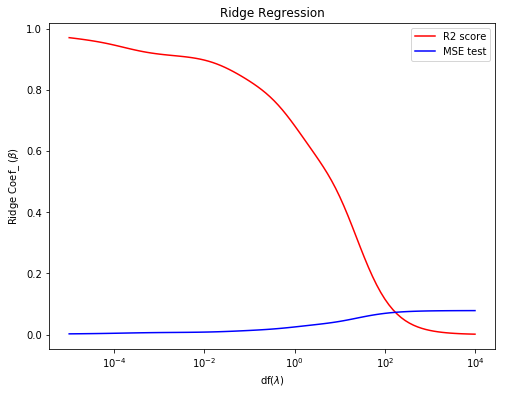

In [40]:
# df(λ) - βcoefficients

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
#plt.gca().invert_xaxis()

#ax.plot(df, coefs)
ax.plot(df, r2, 'r', label='R2 score')
ax.plot(df, mse, 'b', label='MSE test')

plt.xlabel(r'df($\lambda$)')
plt.ylabel(r'Ridge Coef_ ($\beta$)')
plt.title('Ridge Regression')
ax.legend(loc='best')
plt.savefig('RidgeDMcod-coef_MSE_R2.png')
plt.show()
#--------------------------------------------------------


In [ ]:
# Conclusions

Instead of arbitrarily choosing alpha, it would be better to use cross-validation to choose the tuning parameter alpha. 
using the scikit-learn function RidgeCV() 

In [41]:
n_alphas = 1
alphas = np.logspace(-3, 4, n_alphas)

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.001

Then the test MSE associated with this value of $\alpha$  was computeed as

In [42]:
ridge2 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge2.fit(X_train, y_train)
print ("alpha", ridgecv.alpha_, "\nmse",mean_squared_error(y_test, ridge2.predict(X_test)), 
       "\nR2 score",r2_score(y_test, ridge2.predict(X_test)))


alpha 0.001 
mse 0.00651582769199 
R2 score 0.916881826425
